## Quantum Reservoir Computing for Chaotic Dynamics
FYP Masters project by Raihaan Usman

In [1]:
from backend.solver import Lorenz, MFE
from backend import CRCM, QRCM

import numpy as np
import os;  os.environ["OMP_NUM_THREADS"] = '32' # Imposes cores
from matplotlib import pyplot as plt

#### Configuring the dynamical system

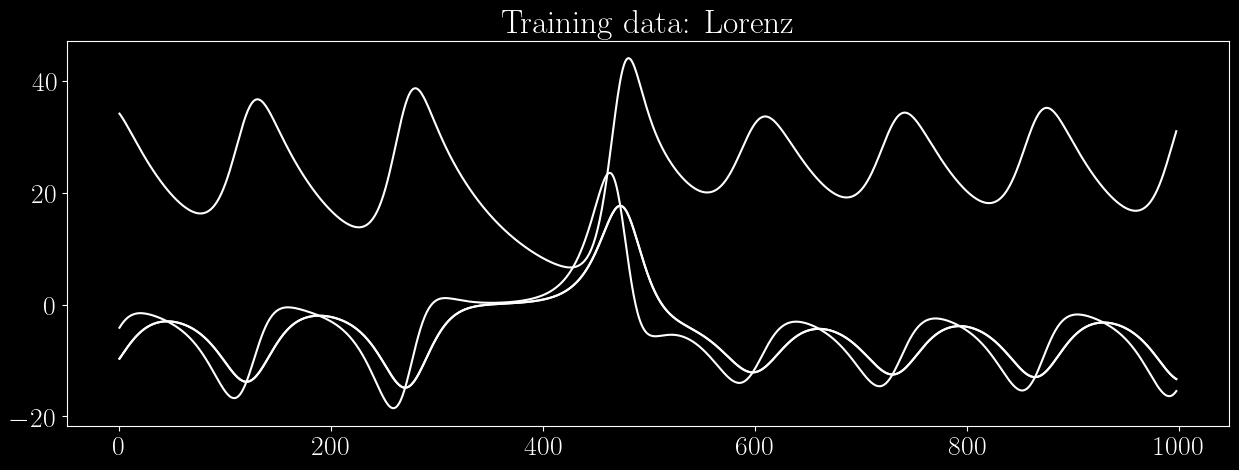

In [2]:
# Data generation parameters
upsample        = 1                     # To increase the dt of the ESN wrt the numerical integrator
dt              = 0.005 * upsample      # Time step
params          = [8/3, 28, 10]         # Parameters for the Lorenz system

# Define N for washout, training, validation and testing
N_washout       = 50
N_train         = 1000
N_test          = 100
N_sets          = [N_washout, N_train, N_test]

# Instantiate the solver object
lor3 = Lorenz(params, dt, N_sets)
lor3.generate(override=True)            # Can always be regenerated with an Autoencoder

#### CRCM for Lorenz system

Closed Loop: 100%|██████████| 99/99 [00:00<00:00, 19819.39it/s]


MSE: 207.57776324548203


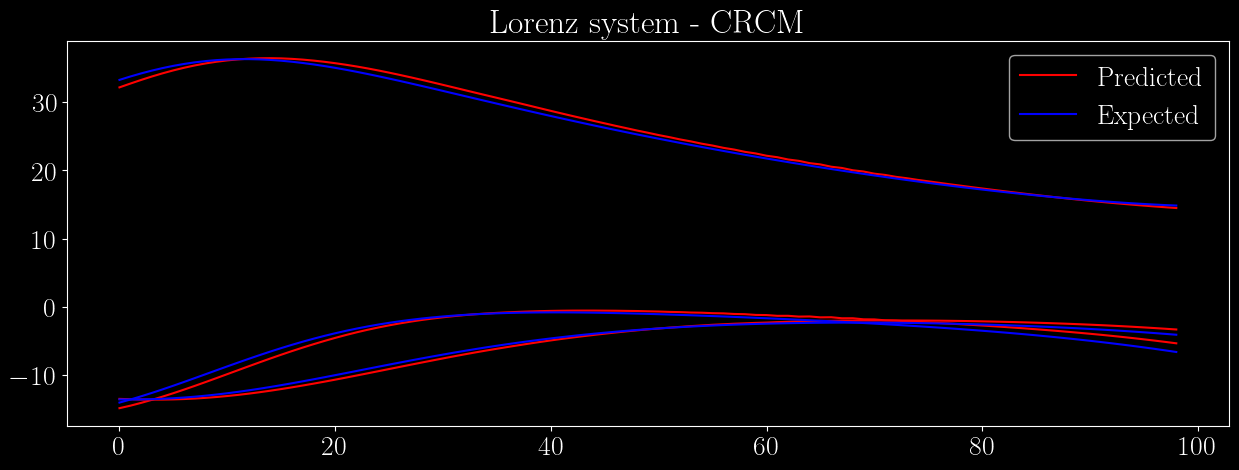

In [3]:
# Initialise the ESN
crcm = CRCM(solver=lor3,
            N_units=500,
            connectivity=10,
            eps= 5e-2,
            tik= 1e-4,
            seed=0)

# Train the ESN with the training data
crcm.train()
crcm.forward()

#### QRCM for Lorenz system

Closed Loop: 100%|██████████| 99/99 [00:11<00:00,  8.76it/s]


MSE: 24462.316313063853


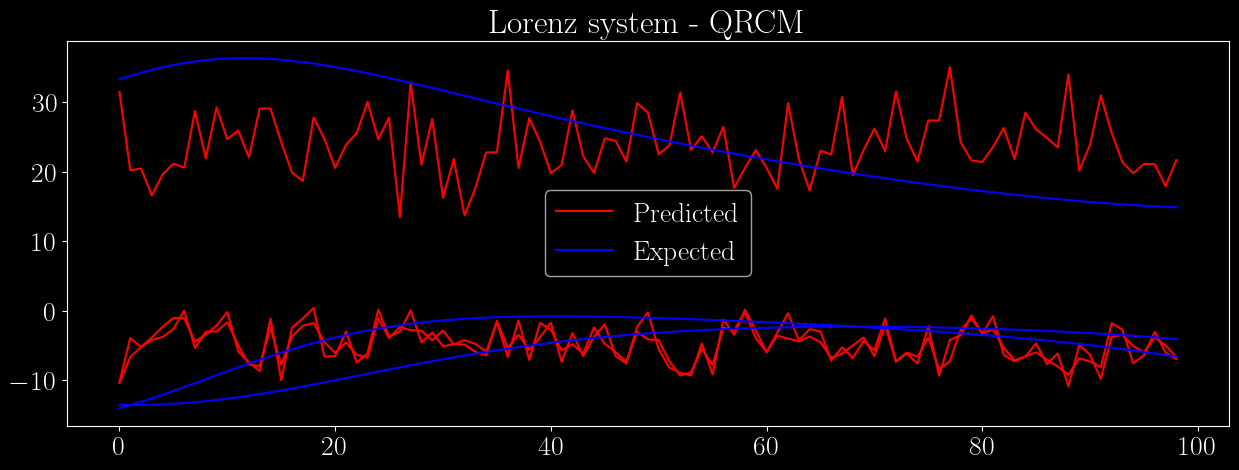

In [5]:
# Instantiate the QRCM object
qrcm = QRCM(solver  = lor3,
            qubits  = 6,
            eps     = 5e-2,
            tik     = 1e-4,
            plot    = True)

# Train the QRCM with the training data
qrcm.train()
qrcm.forward()